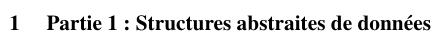



In [36]:
import tkinter as tk
from tkinter import ttk
import random
from datetime import datetime
import emoji

def generer_liste_symbole(taille_max):
    def generer_symbole():
        while True:
            code_point = random.randint(0x1F300, 0x1F9FF) 
            symbole = chr(code_point)
            if emoji.emoji_count(symbole) > 0:
                return symbole
    
    liste_symb = [generer_symbole() for _ in range(random.randint(5, taille_max))]
    return liste_symb

def arrivee_paquet(lamb):
    return random.expovariate(lamb)

def generer_couleur_aleatoire():
    return "#{:02x}{:02x}{:02x}".format(random.randint(50, 255), random.randint(50, 255), random.randint(50, 255))

class Source():
    def __init__(self, id_source, buffer, app, lamb):
        self.id_source = id_source
        self.paquet = None
        self.taux_arrive = lamb
        self.buffer = buffer
        self.app = app
        self.taux_lien = 0.2

    def generer_paquet(self):
        paquet = generer_liste_symbole(30)
        paquet_id = random.randint(1, 1000000)
        print(f"Nouveau paquet généré par la source {self.id_source} : {paquet_id}")
        self.paquet = paquet
        return Paquet(paquet_id, paquet, couleur=generer_couleur_aleatoire(), id_source=self.id_source)

    def envoyer_paquet_buffer(self):
        paquet = self.generer_paquet()
        temps_attente = arrivee_paquet(self.taux_arrive)
        self.buffer.nombre_total_paquets += 1  # incrémenter le nombre total de paquets
        if self.taux_lien < self.taux_arrive:
            if not self.buffer.arrivee_insertion_paquet(paquet):
                paquet.temps_arrive = f"{datetime.now().hour}.{datetime.now().minute}.{datetime.now().second}"
                print("Paquet envoyé vers le Buffer.")
            else:
                self.buffer.ajout_paquets_perdu(paquet)
                self.app.actualiser_affichage()  # actualiser l'affichage pour mettre à jour le taux de paquets perdus
                print("Échec de l'envoi du paquet. Le buffer est plein.")
        else:
            print("Le Paquet est envoyé vers le Lien !")
        
        # ajouter la ligne suivante pour actualiser l'affichage après l'envoi d'un paquet vers le buffer
        self.app.actualiser_affichage()

        # planifier l'envoi du prochain paquet après le temps d'attente
        self.app.after(int(temps_attente * 1000), self.envoyer_paquet_buffer)


class Buffer():
    def __init__(self, capacite):
        self.capacite = capacite
        self.file_attente = []
        self.paquets_perdu = []
        self.lien = []
        self.nombre_total_paquets = 0


    def generer_paquet(self):
        self.nombre_total_paquets += 1  # incrémenter le compteur a chaque génération de paquet
        paquet = generer_liste_symbole(30)
        paquet_id = random.randint(1, 1000000)
        print(f"Nouveau paquet généré : {paquet_id}")
        self.paquet = paquet
        return Paquet(paquet_id, paquet, couleur=generer_couleur_aleatoire(), id_source=None)

    def arrivee_insertion_paquet(self, paquet):
        if len(self.file_attente) < self.capacite:
            self.file_attente.append(paquet)
            return False
        else:
            print("Buffer plein. Le paquet est perdu.")
            self.ajout_paquets_perdu(paquet)  # ajout du paquet perdu dans la liste 
            self.nombre_total_paquets += 1  # incrémenter le compteur pour les paquets perdus
            return True

    def retrait_paquet(self):
        if self.file_attente:
            paquet = self.file_attente.pop(0)
            paquet.temps_depart = f"{datetime.now().hour}.{datetime.now().minute}.{datetime.now().second}" # enregistrer le temps de départ
            return paquet
        else:
            print("La file d'attente est vide. Echec du Retrait!")
            return None

    def ajout_paquets_perdu(self, paquet):
        self.paquets_perdu.append(paquet)  

    def transmission(self, paquet):
        self.lien.append(paquet)

    def nombre_paquets_perdu(self):
        return len(self.paquets_perdu)
        

class Paquet():
    def __init__(self, paquet_id, paquet, couleur, id_source):
        self.paquet_id = paquet_id
        self.id_source = id_source
        self.taille = len(paquet)
        self.paquet = paquet
        self.temps_arrive = None
        self.temps_depart = None
        self.couleur = couleur

class Configuration(tk.Toplevel):
    def __init__(self, parent):
        super().__init__(parent)

        self.title("Configuration de la simulation")
        self.geometry("450x520")

        self.parent = parent
        self.sources_lambda_entrer = []
        self.sources_lambda_label = []

        self.label_sources = ttk.Label(self, text="Nombre sources:", background= "cyan")
        self.label_sources.grid(row=0, column=0, padx=5, pady=5, sticky="e")

        self.sources_var = tk.IntVar(value=3)
        self.entrer_sources = ttk.Entry(self, textvariable=self.sources_var)
        self.entrer_sources.grid(row=0, column=1, padx=5, pady=5)

        self.bouton_valider_sources = ttk.Button(self, text="Valider Nombre Sources", command=self.afficher_champs_lambda)
        self.bouton_valider_sources.grid(row=0, column=2, padx=5, pady=5)

        self.bouton_valider = ttk.Button(self, text="Valider La Config", command=self.valider_configuration)
        self.bouton_valider.grid(row=4, column=0, columnspan=3, padx=5, pady=5)

        self.label_delai_retrait = ttk.Label(self, text="Délai de retrait (secondes):", background= "green")
        self.label_delai_retrait.grid(row=2, column=0, padx=5, pady=5, sticky="e")

        self.delai_retrait_var = tk.DoubleVar(value=0.1)
        self.entrer_delai_retrait = ttk.Entry(self, textvariable=self.delai_retrait_var)
        self.entrer_delai_retrait.grid(row=2, column=1, padx=5, pady=5)

        self.label_capacite_buffer = ttk.Label(self, text="Capacité du buffer:", background= "red")
        self.label_capacite_buffer.grid(row=3, column=0, padx=5, pady=5, sticky="e")

        self.capacite_buffer_var = tk.IntVar(value=20)
        self.entrer_capacite_buffer = ttk.Entry(self, textvariable=self.capacite_buffer_var)
        self.entrer_capacite_buffer.grid(row=3, column=1, padx=5, pady=5)

    def afficher_champs_lambda(self):
        sources = self.sources_var.get()
        # Nettoyer les entrées lambda existantes
        for entry in self.sources_lambda_entrer:
            entry.destroy()
        for label in self.sources_lambda_label:
            label.destroy()
        self.sources_lambda_entrer = []
        self.sources_lambda_label = []
        # Créer des champs lambda pour chaque source
        for i in range(sources):
            label_lambda = ttk.Label(self, text=f"Lambda Source {i+1}:")
            label_lambda.grid(row=i+5, column=0, padx=5, pady=5, sticky="e")
            self.sources_lambda_label.append(label_lambda)

            lambda_var = tk.DoubleVar(value=0.5)
            entrer_lambda = ttk.Entry(self, textvariable=lambda_var)
            entrer_lambda.grid(row=i+5, column=1, padx=5, pady=5)
            self.bouton_valider.grid(row=i+7, column=0, columnspan=3, padx=5, pady=15)
            self.sources_lambda_entrer.append(entrer_lambda)

    def valider_configuration(self):
        lambda_values = [entry.get() for entry in self.sources_lambda_entrer]
        delai_retrait = self.delai_retrait_var.get()
        capacite_buffer = self.capacite_buffer_var.get()
        self.parent.configurer_simulation(lambda_values, delai_retrait, capacite_buffer)
        self.destroy()

class Application(tk.Tk):
    def __init__(self):
        super().__init__()

        self.title("Simulation de buffer")

        self.attributes("-fullscreen", True)

        self.cadre_buffer = ttk.Frame(self)
        self.cadre_buffer.pack(fill=tk.BOTH, expand=True)

        self.titre_buffer = ttk.Label(self.cadre_buffer, text="Buffer", style="Titre.TLabel")
        self.titre_buffer.pack()

        self.cadre_scrollable_buffer = ttk.Frame(self.cadre_buffer)
        self.cadre_scrollable_buffer.pack(fill=tk.BOTH, expand=True)

        self.scrollbar_buffer_y = tk.Scrollbar(self.cadre_scrollable_buffer, orient="vertical")
        self.scrollbar_buffer_y.pack(side=tk.RIGHT, fill=tk.Y)

        self.canvas_buffer = tk.Canvas(self.cadre_scrollable_buffer, bg="lightgray", yscrollcommand=self.scrollbar_buffer_y.set)
        self.canvas_buffer.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        self.scrollbar_buffer_y.config(command=self.canvas_buffer.yview)

        self.cadre_lien = ttk.Frame(self)
        self.cadre_lien.pack(fill=tk.BOTH, expand=True)

        self.titre_lien = ttk.Label(self.cadre_lien, text="Lien", style="Titre.TLabel")
        self.titre_lien.pack()

        self.scrollbar_lien_y = tk.Scrollbar(self.cadre_lien, orient="vertical")
        self.scrollbar_lien_y.pack(side=tk.RIGHT, fill=tk.Y)

        self.canvas_lien = tk.Canvas(self.cadre_lien, bg="lightgray", yscrollcommand=self.scrollbar_lien_y.set, name="lien")
        self.canvas_lien.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        self.scrollbar_lien_y.config(command=self.canvas_lien.yview)

        self.texte_infos = tk.Text(self, height=10, width=50)
        self.texte_infos.pack()

        self.label_paquets_perdus = ttk.Label(self, text="Nombre de paquets perdus : 0", style="Titre.TLabel")
        self.label_paquets_perdus.pack()

        self.label_taux_paquets_perdu = ttk.Label(self, text="Taux de paquets perdus : 0%", style="Titre.TLabel")
        self.label_taux_paquets_perdu.pack()

        self.canvas_buffer.bind("<Button-1>", self.afficher_info_paquet)
        self.canvas_lien.bind("<Button-1>", self.afficher_info_paquet_lien)

        self.menu = Configuration(self)

        # personnaliser le style
        self.style = ttk.Style()
        self.style.theme_use("clam")
        self.style.configure(
            "Titre.TLabel",
            foreground="white",
            background="black",
            font=("Helvetica", 14, "bold"))

        self.menu.transient(self)
        self.menu.grab_set()
        self.wait_window(self.menu)

    def configurer_simulation(self, lambdas, delai_retrait, capacite_buffer):
        self.buffer = Buffer(capacite_buffer)
        self.sources = []
        self.delai_coef_retrait = delai_retrait

        for i, lamb in enumerate(lambdas):
            source = Source(id_source=i+1, buffer=self.buffer, app=self, lamb=float(lamb))
            self.sources.append(source)
        

        self.after(1000, self.lancer_simulation)
        self.after(1000, self.retrait_periodique_paquet)

    def lancer_simulation(self):
        for source in self.sources:
            source.envoyer_paquet_buffer()

    def retrait_periodique_paquet(self):
        if self.buffer.file_attente:
            paquet = self.buffer.retrait_paquet()  # retrait d'un paquet du buffer
            if paquet:
                # calcul du temps d'attente en fonction de la taille du paquet
                temps_attente = paquet.taille * self.delai_coef_retrait  # utilisation du délai de retrait
                self.buffer.transmission(paquet)  # ajout du paquet retiré dans le lien
                self.actualiser_affichage()
                self.after(int(temps_attente * 1000), self.retrait_periodique_paquet)
                # vérifier si le buffer n'est pas vide, et planifier le prochain retrait
        else:
            self.after(1000, self.retrait_periodique_paquet)

    def actualiser_affichage(self):
        largeur_buffer = self.canvas_buffer.winfo_width() - 20
        hauteur_buffer = self.buffer.capacite * 5 + 20  # hauteur variable en fonction du nombre de paquets

        # supprimer tous les éléments existants du canvas buffer
        self.canvas_buffer.delete("all")

        decalage_x = 10
        decalage_y = 10
        for paquet in self.buffer.file_attente:
            largeur_paquet = paquet.taille * 10
            if decalage_x + largeur_paquet > largeur_buffer:
                decalage_x = 10
                decalage_y += 35
            x0 = decalage_x
            y0 = decalage_y
            x1 = x0 + largeur_paquet
            y1 = y0 + 30

            couleur_fill = paquet.couleur

            bouton_id = f"paquet_{paquet.paquet_id}"
            self.canvas_buffer.create_rectangle(x0, y0, x1, y1, fill=couleur_fill, tags=bouton_id)
            self.canvas_buffer.create_text((x0 + x1) / 2, (y0 + y1) / 2, text=f"{paquet.paquet_id}", tags=bouton_id)

            decalage_x += largeur_paquet + 5

        # ajustement de la taille du canvas du buffer
        self.canvas_buffer.config(scrollregion=(0, 0, largeur_buffer, hauteur_buffer))

        # affichage des paquets transmis
        largeur_lien = self.canvas_lien.winfo_width() - 20
        hauteur_lien = len(self.buffer.lien) * 4 + 20  # hauteur variable en fonction du nombre de paquets transmis

        # supprimer tous les éléments existants du canvas des paquets transmis
        self.canvas_lien.delete("all")

        decalage_x_lien = 10
        decalage_y_lien = 10
        for paquet in self.buffer.lien:
            largeur_paquet = paquet.taille * 10
            if decalage_x_lien + largeur_paquet > largeur_lien:
                decalage_x_lien = 10
                decalage_y_lien += 35
            x0 = decalage_x_lien
            y0 = decalage_y_lien
            x1 = x0 + largeur_paquet
            y1 = y0 + 30

            bouton_id = f"paquet_lien_{paquet.paquet_id}"
            self.canvas_lien.create_rectangle(x0, y0, x1, y1, fill="green", tags=bouton_id)
            self.canvas_lien.create_text((x0 + x1) / 2, (y0 + y1) / 2, text=f"{paquet.paquet_id}", tags=bouton_id)

            decalage_x_lien += largeur_paquet + 5

        # ajustement de la taille du canvas pour les paquets transmis
        self.canvas_lien.config(scrollregion=(0, 0, largeur_lien, hauteur_lien))

        # mise à jour du nombre de paquets perdus
        nb_paquets_perdus = self.buffer.nombre_paquets_perdu()
        self.label_paquets_perdus.config(text=f"Nombre de paquets perdus : {nb_paquets_perdus}")
        
        # mise à jour du taux de paquets perdus
        self.label_taux_paquets_perdu.config(text=f"Taux de paquets perdus : {round((nb_paquets_perdus/ self.buffer.nombre_total_paquets) * 100, 2) if self.buffer.nombre_total_paquets > 0 else 0}%")

    def afficher_info_paquet(self, event):
        tags = self.canvas_buffer.gettags(tk.CURRENT)
        if tags:
            paquet_id = int(tags[0].split("_")[1])
            for paquet in self.buffer.file_attente:
                if paquet.paquet_id == paquet_id:
                    self.afficher_info_paquet_dans_texte(paquet)
                    return

    def afficher_info_paquet_lien(self, event):
        tags = self.canvas_lien.gettags(tk.CURRENT)
        if tags:
            paquet_id = int(tags[0].split("_")[2])
            for paquet in self.buffer.lien:
                if paquet.paquet_id == paquet_id:
                    self.afficher_info_paquet_dans_texte(paquet)
                    return

    def afficher_info_paquet_dans_texte(self, paquet):
        self.texte_infos.delete("1.0", tk.END)
        self.texte_infos.insert(tk.END, f"ID Paquet : {paquet.paquet_id}\nSource : {paquet.id_source}\nContenu Paquet : {paquet.paquet}\nTaille : {paquet.taille}\nTemps d'arrivée : {paquet.temps_arrive}\nTemps de départ : {paquet.temps_depart}\n")

if __name__ == "__main__":
    app = Application() 
    app.mainloop()

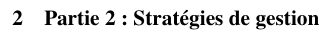

In [ ]:
#a faire